In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns

/home/nvrancovich/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
segments = gpd.read_file('segmentacion_general_san_martin.geojson')
segments.rename(columns={'name':'area', 'description':'region'},inplace=True)
segments

,area,region,geometry
0,Lynch - Sur,Villa Lynch,"POLYGON Z ((-58.52226 -34.59736 0.00000, -58.5..."
1,Villa Maipu,Villa Maipu,"POLYGON Z ((-58.51502 -34.58139 0.00000, -58.5..."
2,San Martin,San Martin,"POLYGON Z ((-58.54791 -34.57601 0.00000, -58.5..."
3,Billinghurst - Norte,Billinghurst,"POLYGON Z ((-58.57804 -34.57871 0.00000, -58.5..."
4,Loma Hermosa,Loma Hermosa,"POLYGON Z ((-58.59056 -34.56881 0.00000, -58.5..."
5,San Andres - Norte,San Andres,"POLYGON Z ((-58.53783 -34.54422 0.00000, -58.5..."
6,Ballester - Las Heras Norte,Villa Ballester,"POLYGON Z ((-58.54942 -34.56177 0.00000, -58.5..."
7,Ballester - Gral. Guido,Villa Ballester,"POLYGON Z ((-58.58009 -34.54998 0.00000, -58.5..."
8,Ballester - VIlla De Sucre,Villa Ballester,"POLYGON Z ((-58.56118 -34.54686 0.00000, -58.5..."
9,Lynch - Villa Chacabuco,Villa Lynch,"POLYGON Z ((-58.53731 -34.58467 0.00000, -58.5..."


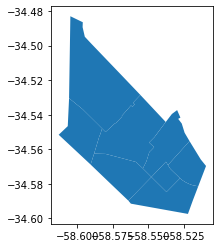

In [3]:
segments.dissolve(by='region').plot()

In [4]:
props = pd.read_csv('features_propiedades_4371.csv')
props = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
props = props.set_crs('EPSG:4326')

In [5]:
join = props.sjoin(segments, how='inner')

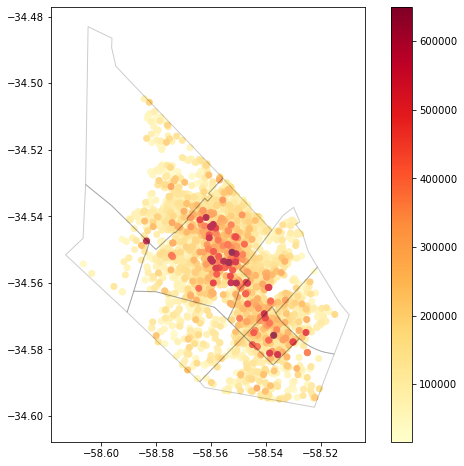

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
join.sort_values('price_USD').plot(ax=ax, column = 'price_USD', cmap = 'YlOrRd', legend=True,linewidth=1)
segments.dissolve(by='region').plot(ax=ax, alpha=0.2, edgecolor='Black', facecolor='White')
plt.show()

In [7]:
join['price/m2'] =  join.price_USD / join.covered_surface_m2

In [8]:
join.drop(axis=1, labels=['Unnamed: 0'], inplace=True)

# Limpieza

Primero mediante algunas graficas rapidas me doy cuenta que hay valores demasiado alejados del promedio, propiedades que tienen muy pocos metros cuadrados y con valores altisimos. Propiedades con valores altisimos demasiado elejados de la mediana de la zona. Asi que los limpio.

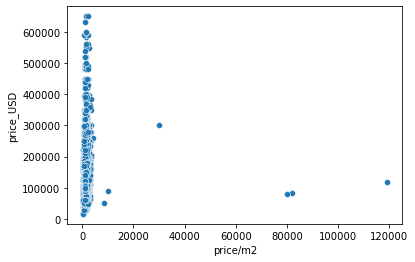

In [9]:
sns.scatterplot(x=join['price/m2'], y=join.price_USD)

In [10]:
join = join[join.covered_surface_m2 > 15]

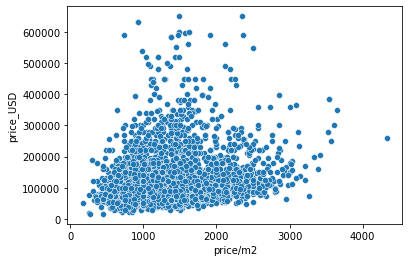

In [11]:
sns.scatterplot(x=join['price/m2'], y=join.price_USD)

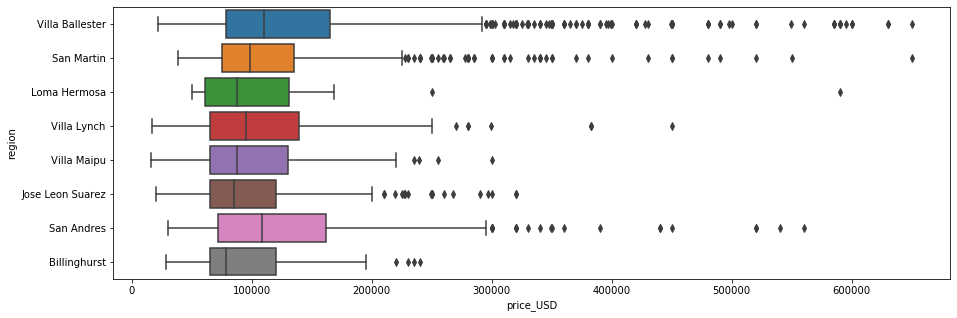

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(x=join.price_USD, y=join.region)

In [13]:
for i in list(join['area'].unique()):
    q = join[join['area'] == i].price_USD.quantile(0.90)
    join[join['area'] == i] = join[(join['area'] == i) & (join.price_USD < q)]

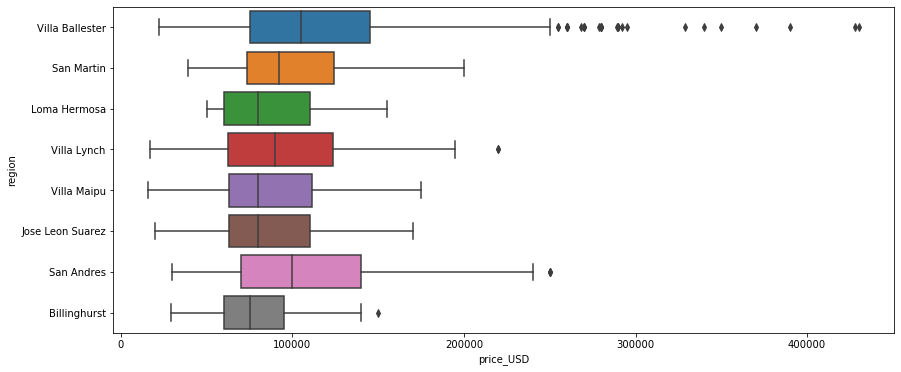

In [14]:
plt.figure(figsize=(14,6))
sns.boxplot(x=join.price_USD, y=join.region)

# Promedios

In [31]:
segments_avg = join.groupby('area').mean()[['covered_surface_m2', 'antiquity', 'price_USD', 'price/m2']].reset_index(level=0)
segments_avg[['area','price/m2']].to_csv('promedios_segmentos.csv')


In [16]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "price_USD"],
    key_on= 'feature.properties.area',
    fill_color='RdYlGn_r',
    bins = 11,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Precio promedio en USD',
).add_to(m)

m

In [17]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "antiquity"],
    key_on= 'feature.properties.area',
    fill_color='GnBu',
    bins = 8,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Antiguedad promedio en años',
).add_to(m)

m

In [18]:
m = folium.Map(location=[-34.55, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='choropleth',
    data=segments_avg,
    columns=["area", "price/m2"],
    key_on= 'feature.properties.area',
    fill_color='RdYlGn_r',
    bins = 11,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Precio promedio por metro cuadrado en USD',
).add_to(m)

m

In [19]:
m = folium.Map(location=[-34.555, -58.56], zoom_start=12.5)

folium.Choropleth(
    geo_data=segments,
    name='superficie promedio m2',
    data=segments_avg,
    columns=["area", "covered_surface_m2"],
    key_on= 'feature.properties.area',
    fill_color='Greens',
    bins = 9,
    highlight = 'True',
    fill_opacity=0.7,
    line_opacity=0.7,
    legend_name='Superficie promedio en metros cuadrados',
).add_to(m)

m

In [20]:
join.groupby('area').price_USD.describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,167.0,136051.497006,52912.146846,50000.0,90000.0,125000.0,160000.00,289100.0
Ballester - Alvear Sur,166.0,123212.650602,55979.133744,47000.0,79925.0,106000.0,153750.00,295000.0
Ballester - Gral. Guido,362.0,105455.798343,40756.534535,35000.0,75000.0,97500.0,133750.00,210000.0
Ballester - Las Heras Norte,70.0,160414.285714,101079.892761,42000.0,79250.0,125000.0,230000.00,430000.0
Ballester - Las Heras Sur,115.0,113930.434783,52116.514495,40000.0,74000.0,99000.0,145000.00,249500.0
Ballester - Norte,315.0,113882.219048,51020.861170,22000.0,70000.0,105000.0,145000.00,255000.0
Ballester - VIlla De Sucre,86.0,111468.604651,45717.776853,30000.0,69750.0,107500.0,140000.00,200000.0
Ballester - Villa Zapiola,73.0,80643.835616,25420.557004,35000.0,65000.0,79000.0,90000.00,145000.0
Billinghurst - Norte,45.0,78140.000000,25405.174849,30000.0,59000.0,75000.0,95000.00,140000.0


In [21]:
join.groupby('region').price_USD.describe().reset_index()

,region,count,mean,std,min,25%,50%,75%,max
0,Billinghurst,131.0,80481.679389,28455.365322,29000.0,60000.0,75000.0,95000.00,150000.0
1,Jose Leon Suarez,322.0,85695.108696,32318.478840,20000.0,63250.0,80000.0,110000.00,170000.0
2,Loma Hermosa,21.0,89071.428571,32518.566125,50000.0,60000.0,80000.0,110000.00,155000.0
3,San Andres,439.0,109429.831435,47513.961672,30000.0,70000.0,100000.0,140000.00,250000.0
4,San Martin,535.0,100669.117757,35650.320614,39000.0,73750.0,92000.0,124500.00,200000.0
5,Villa Ballester,1354.0,115972.007386,54282.157870,22000.0,75000.0,105000.0,145000.00,430000.0
6,Villa Lynch,163.0,95732.453988,39188.119611,17000.0,62500.0,90000.0,123500.00,220000.0
7,Villa Maipu,108.0,88038.592593,36021.959817,16000.0,63000.0,79974.5,111249.75,175000.0


In [22]:
join.groupby('area')['price/m2'].describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,167.0,2070.572262,453.142403,842.553191,1771.241830,2121.951220,2319.826908,3571.428571
Ballester - Alvear Sur,166.0,1888.440303,529.065255,566.666667,1573.308271,1911.538462,2226.984127,3531.645570
Ballester - Gral. Guido,362.0,1521.759631,498.671662,469.879518,1114.583333,1533.333333,1835.884354,2924.528302
Ballester - Las Heras Norte,70.0,1765.785705,490.360441,814.814815,1467.964824,1774.615385,2027.469758,3260.869565
Ballester - Las Heras Sur,115.0,1175.782240,359.108095,360.000000,958.653026,1157.142857,1369.318182,2271.428571
Ballester - Norte,315.0,1483.562826,465.119051,416.666667,1125.000000,1494.252874,1750.000000,3416.666667
Ballester - VIlla De Sucre,86.0,1340.613512,400.430925,555.555556,1079.272363,1311.666667,1611.883943,2250.000000
Ballester - Villa Zapiola,73.0,899.105563,300.069197,350.000000,684.210526,866.666667,1089.743590,1739.130435
Billinghurst - Norte,45.0,926.598049,379.082397,451.388889,700.000000,893.939394,1000.000000,2316.666667


In [23]:
join.groupby('area')['covered_surface_m2'].describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
Ballester - Alvear Norte,167.0,69.455090,37.368679,22.0,47.00,60.0,80.5,245.0
Ballester - Alvear Sur,166.0,73.765060,53.051367,22.0,44.25,52.5,80.0,300.0
Ballester - Gral. Guido,362.0,79.853591,50.826500,20.0,45.00,60.0,100.0,415.0
Ballester - Las Heras Norte,70.0,102.157143,79.429603,23.0,42.25,70.0,127.5,310.0
Ballester - Las Heras Sur,115.0,107.869565,70.250744,31.0,56.00,96.0,128.5,500.0
Ballester - Norte,315.0,85.317460,50.952777,25.0,47.00,70.0,110.0,291.0
Ballester - VIlla De Sucre,86.0,93.697674,52.463785,20.0,44.00,86.0,120.0,250.0
Ballester - Villa Zapiola,73.0,100.616438,45.986601,28.0,65.00,90.0,134.0,200.0
Billinghurst - Norte,45.0,98.311111,52.695015,26.0,62.00,90.0,120.0,271.0


In [24]:
join.price_USD.mean()

105448.6674259681

In [25]:
join.price_USD.std()

47508.52758827783

In [26]:
join.covered_surface_m2.mean()

82.52554506996421

In [27]:
join.antiquity.mean()

21.9936766034327

In [28]:
sellers = join.groupby('seller').count()
sellers['percentage'] = sellers.type / sellers.type.sum()
sellers.rename(columns={'type':'count'}, inplace=True)
sellers = sellers[['count','percentage']].reset_index()
sellers

,seller,count,percentage
0,A. Romero,8,0.002603
1,ABDUCH PROPIEDADES,89,0.028962
2,AJB BIENES RAICES,6,0.001952
3,ALAN FANATICO GESTION INMOBILIARIA,65,0.021152
4,ALAN FANATICO GESTION INMOBILIARIA SUC.1,70,0.022779
...,...,...,...
241,VENINI ACTIVIDADES INMOBILIARIAS,2,0.000651
242,Verabel Negocios Inmobiliarios,1,0.000325
243,WAIMAN PROPIEDADES,1,0.000325
244,ZAMBORAIN CABRERA PROPIEDADES,1,0.000325


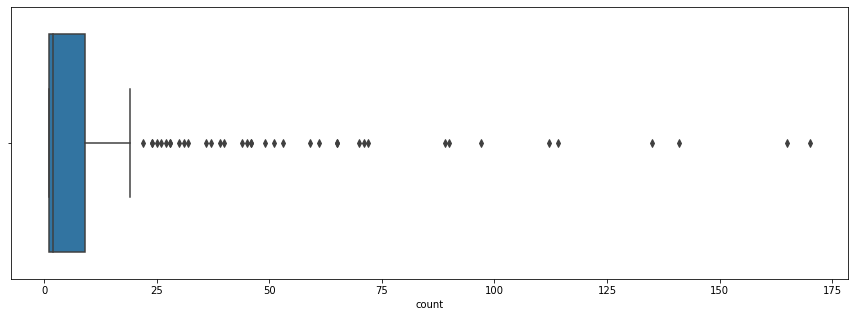

In [29]:
plt.figure(figsize=(15,5))
sns.boxplot(x=sellers['count'])